# 🗑️ Garbage Classification for Edge Devices (Google Colab)

**Train an AI model to classify garbage into 12 categories using TensorFlow and convert it to TensorFlow Lite for deployment on mobile or edge devices.**

📱 **Target**: Edge deployment with TensorFlow Lite  
🎯 **Model**: EfficientNetB0 with transfer learning  
📊 **Dataset**: 12 garbage categories from Kaggle  
☁️ **Platform**: Google Colab with GPU acceleration  

---

## 🚀 Quick Start
1. **Run all cells** in order
2. Model will be saved to **Google Drive** automatically
3. **TFLite models** ready for mobile deployment

In [ ]:
# 🔧 Google Colab Environment Setup
print("🚀 Setting up Google Colab environment...")

# Check if running on Colab
try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")
except ImportError:
    IN_COLAB = False
    print("ℹ️  Running locally")

# GPU Check
import tensorflow as tf
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU available for training")
    print(f"📊 GPU devices: {tf.config.list_physical_devices('GPU')}")
else:
    print("⚠️  No GPU found - training will be slower")

print(f"🐍 TensorFlow version: {tf.__version__}")

🚀 Setting up Google Colab environment...
✅ Running on Google Colab
✅ GPU available for training
📊 GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
🐍 TensorFlow version: 2.18.0


In [ ]:
# 💾 Mount Google Drive (for saving models)
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # Create model save directory
    import os
    DRIVE_MODEL_DIR = '/content/drive/MyDrive/garbage_classification_models'
    os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)
    print(f"✅ Google Drive mounted")
    print(f"📁 Models will be saved to: {DRIVE_MODEL_DIR}")
else:
    DRIVE_MODEL_DIR = './models'
    os.makedirs(DRIVE_MODEL_DIR, exist_ok=True)
    print(f"📁 Models will be saved to: {DRIVE_MODEL_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 Models will be saved to: /content/drive/MyDrive/garbage_classification_models


In [ ]:
# 📥 Download Dataset using KaggleHub
print("📥 Downloading garbage classification dataset...")

# Install kagglehub if needed
try:
    import kagglehub
except ImportError:
    print("Installing kagglehub...")
    !pip install kagglehub
    import kagglehub

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("✅ Dataset downloaded successfully!")
print("📁 Path to dataset files:", path)

# The actual dataset is in a subdirectory
import os
DATASET_PATH = os.path.join(path, 'garbage_classification')
print(f"🗂️  Dataset location: {DATASET_PATH}")

# Verify dataset structure
if os.path.exists(DATASET_PATH):
    categories = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    print(f"📊 Found {len(categories)} categories: {categories}")
else:
    print("❌ Dataset path not found!")

📥 Downloading garbage classification dataset...
✅ Dataset downloaded successfully!
📁 Path to dataset files: /kaggle/input/garbage-classification
🗂️  Dataset location: /kaggle/input/garbage-classification/garbage_classification
📊 Found 12 categories: ['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


# 🗑️ Garbage Classification Model Training (Google Colab Edition)

This notebook demonstrates training a garbage classification model using **EfficientNetB0** with transfer learning for deployment on edge devices.

## 🎆 Overview
- **Dataset**: 12 categories of garbage classification (Downloaded via KaggleHub)
- **Model**: EfficientNetB0 (transfer learning with fine-tuning)
- **Target**: TensorFlow Lite for edge deployment
- **Platform**: Google Colab with GPU acceleration
- **Storage**: Models automatically saved to Google Drive
- **Categories**: battery, biological, brown-glass, cardboard, clothes, green-glass, metal, paper, plastic, shoes, trash, white-glass

## 🚀 Features
- ☁️ **Google Colab** optimized
- 💾 **Auto-save to Google Drive**
- 📊 **Enhanced data augmentation**
- 📱 **TensorFlow Lite conversion**
- 📈 **Comprehensive visualizations**

## 1. Import Dependencies

In [ ]:
# 📦 Import All Required Libraries
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Dropout,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast,
    RandomBrightness, RandomTranslation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,
    TensorBoard
)
from tensorflow.keras.metrics import TopKCategoricalAccuracy

import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import os
import numpy as np
from PIL import Image
import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Set memory growth for GPU
if len(tf.config.list_physical_devices('GPU')) > 0:
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

print(f"✅ TensorFlow version: {tf.__version__}")
print(f"📊 GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
print(f"🌱 Random seeds set for reproducibility")

✅ TensorFlow version: 2.18.0
📊 GPU Available: True
🌱 Random seeds set for reproducibility


## 2. Configuration

In [ ]:
# Training configuration
CONFIG = {
    # Dataset
    'DATA_DIR': DATASET_PATH,
    'IMAGE_SIZE': (224, 224),
    'NUM_CLASSES': len(categories),

    # Training
    'BATCH_SIZE': 16,  # Increased for better training
    'EPOCHS': 20,      # More epochs for better learning
    'VALIDATION_SPLIT': 0.2,
    'SEED': 42,

    # Model
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.3,
    'FINE_TUNE_AT': 150,  # Unfreeze top layers

    # Data Augmentation
    'AUGMENTATION_STRENGTH': 0.2,

    # Callbacks
    'PATIENCE': 5,
    'MONITOR': 'val_accuracy',
    'MODE': 'max',

    # Paths
    'MODEL_SAVE_DIR': DRIVE_MODEL_DIR
}

print("🚀 Enhanced Training Configuration:")
print("=" * 50)
for key, value in CONFIG.items():
    print(f"  {key:<20}: {value}")

print(f"\n📁 Dataset categories ({CONFIG['NUM_CLASSES']}): {categories}")

🚀 Enhanced Training Configuration:
  DATA_DIR            : /kaggle/input/garbage-classification/garbage_classification
  IMAGE_SIZE          : (224, 224)
  NUM_CLASSES         : 12
  BATCH_SIZE          : 16
  EPOCHS              : 20
  VALIDATION_SPLIT    : 0.2
  SEED                : 42
  LEARNING_RATE       : 0.001
  DROPOUT_RATE        : 0.3
  FINE_TUNE_AT        : 150
  AUGMENTATION_STRENGTH: 0.2
  PATIENCE            : 5
  MONITOR             : val_accuracy
  MODE                : max
  MODEL_SAVE_DIR      : /content/drive/MyDrive/garbage_classification_models

📁 Dataset categories (12): ['metal', 'white-glass', 'biological', 'paper', 'brown-glass', 'battery', 'trash', 'cardboard', 'shoes', 'clothes', 'plastic', 'green-glass']


## 3. Dataset Exploration

In [ ]:
# Check dataset structure
data_dir = pathlib.Path(CONFIG['DATA_DIR'])

if not data_dir.exists():
    raise FileNotFoundError(f"Dataset directory '{CONFIG['DATA_DIR']}' not found!")

# Get class directories and names
class_dirs = [d for d in data_dir.iterdir() if d.is_dir()]
class_names = sorted([d.name for d in class_dirs])
num_classes = len(class_names)

print(f"📊 Found {num_classes} garbage categories:")
print("=" * 60)

# Count images per class
class_counts = []
for i, class_name in enumerate(class_names):
    class_path = data_dir / class_name
    # Count all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_count = sum([len(list(class_path.glob(ext))) for ext in image_extensions])
    class_counts.append(image_count)
    print(f"  {i+1:2d}. {class_name:<15} - {image_count:5d} images")

total_images = sum(class_counts)
print(f"\n🖼️  Total images: {total_images:,}")
print(f"📊 Average per class: {total_images // num_classes:,}")
print(f"📈 Min images: {min(class_counts):,} | Max images: {max(class_counts):,}")

# Update CONFIG with actual class names
CONFIG['CLASS_NAMES'] = class_names
CONFIG['NUM_CLASSES'] = num_classes

📊 Found 12 garbage categories:
   1. battery         -   945 images
   2. biological      -   985 images
   3. brown-glass     -   607 images
   4. cardboard       -   891 images
   5. clothes         -  5325 images
   6. green-glass     -   629 images
   7. metal           -   769 images
   8. paper           -  1050 images
   9. plastic         -   865 images
  10. shoes           -  1977 images
  11. trash           -   697 images
  12. white-glass     -   775 images

🖼️  Total images: 15,515
📊 Average per class: 1,292
📈 Min images: 607 | Max images: 5,325


## 4. Data Visualization

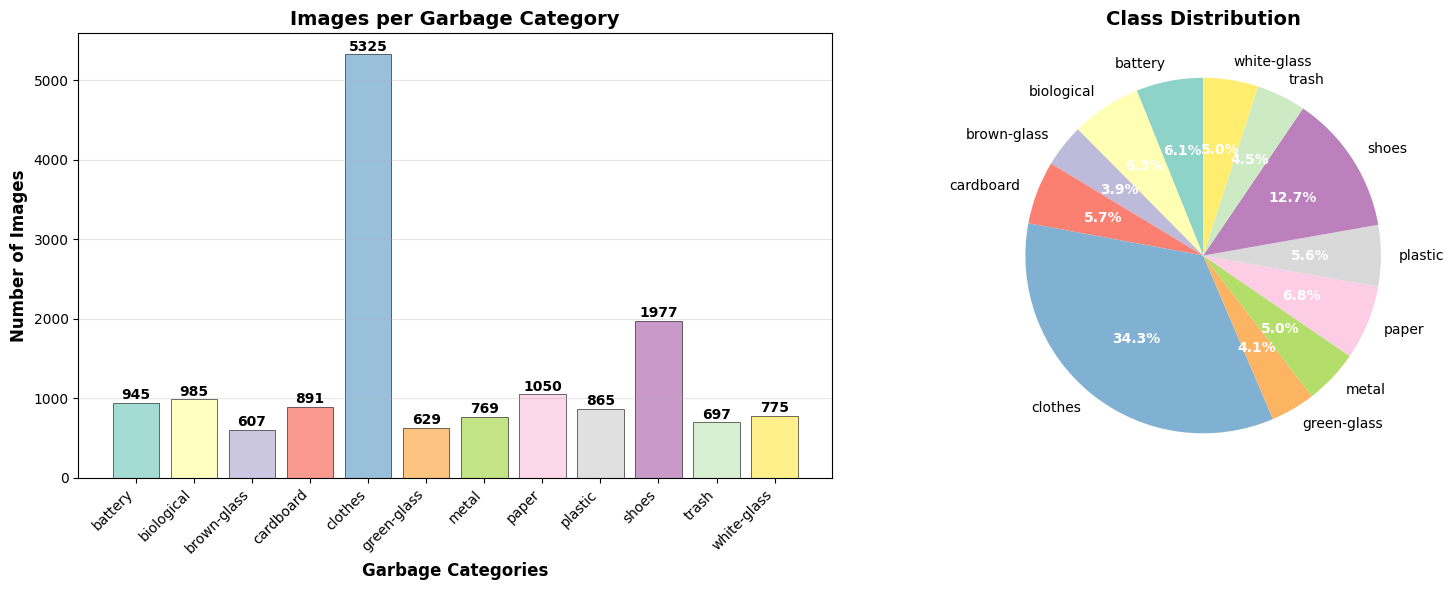


📊 Dataset Statistics:
  Total images: 15,515
  Training images (~80%): 12,412
  Validation images (~20%): 3,103
  Most common class: clothes (5,325 images)
  Least common class: brown-glass (607 images)


In [ ]:
# 📊 Enhanced Class Distribution Visualization
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
bars = ax1.bar(range(len(class_names)), class_counts, color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Garbage Categories', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax1.set_title('Images per Garbage Category', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(class_names)))
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# Pie chart
wedges, texts, autotexts = ax2.pie(class_counts, labels=class_names, autopct='%1.1f%%',
                                   colors=colors, startangle=90)
ax2.set_title('Class Distribution', fontsize=14, fontweight='bold')

# Enhance pie chart text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Statistics summary
print(f"\n📊 Dataset Statistics:")
print(f"  Total images: {total_images:,}")
print(f"  Training images (~80%): {int(total_images * 0.8):,}")
print(f"  Validation images (~20%): {int(total_images * 0.2):,}")
print(f"  Most common class: {class_names[np.argmax(class_counts)]} ({max(class_counts):,} images)")
print(f"  Least common class: {class_names[np.argmin(class_counts)]} ({min(class_counts):,} images)")

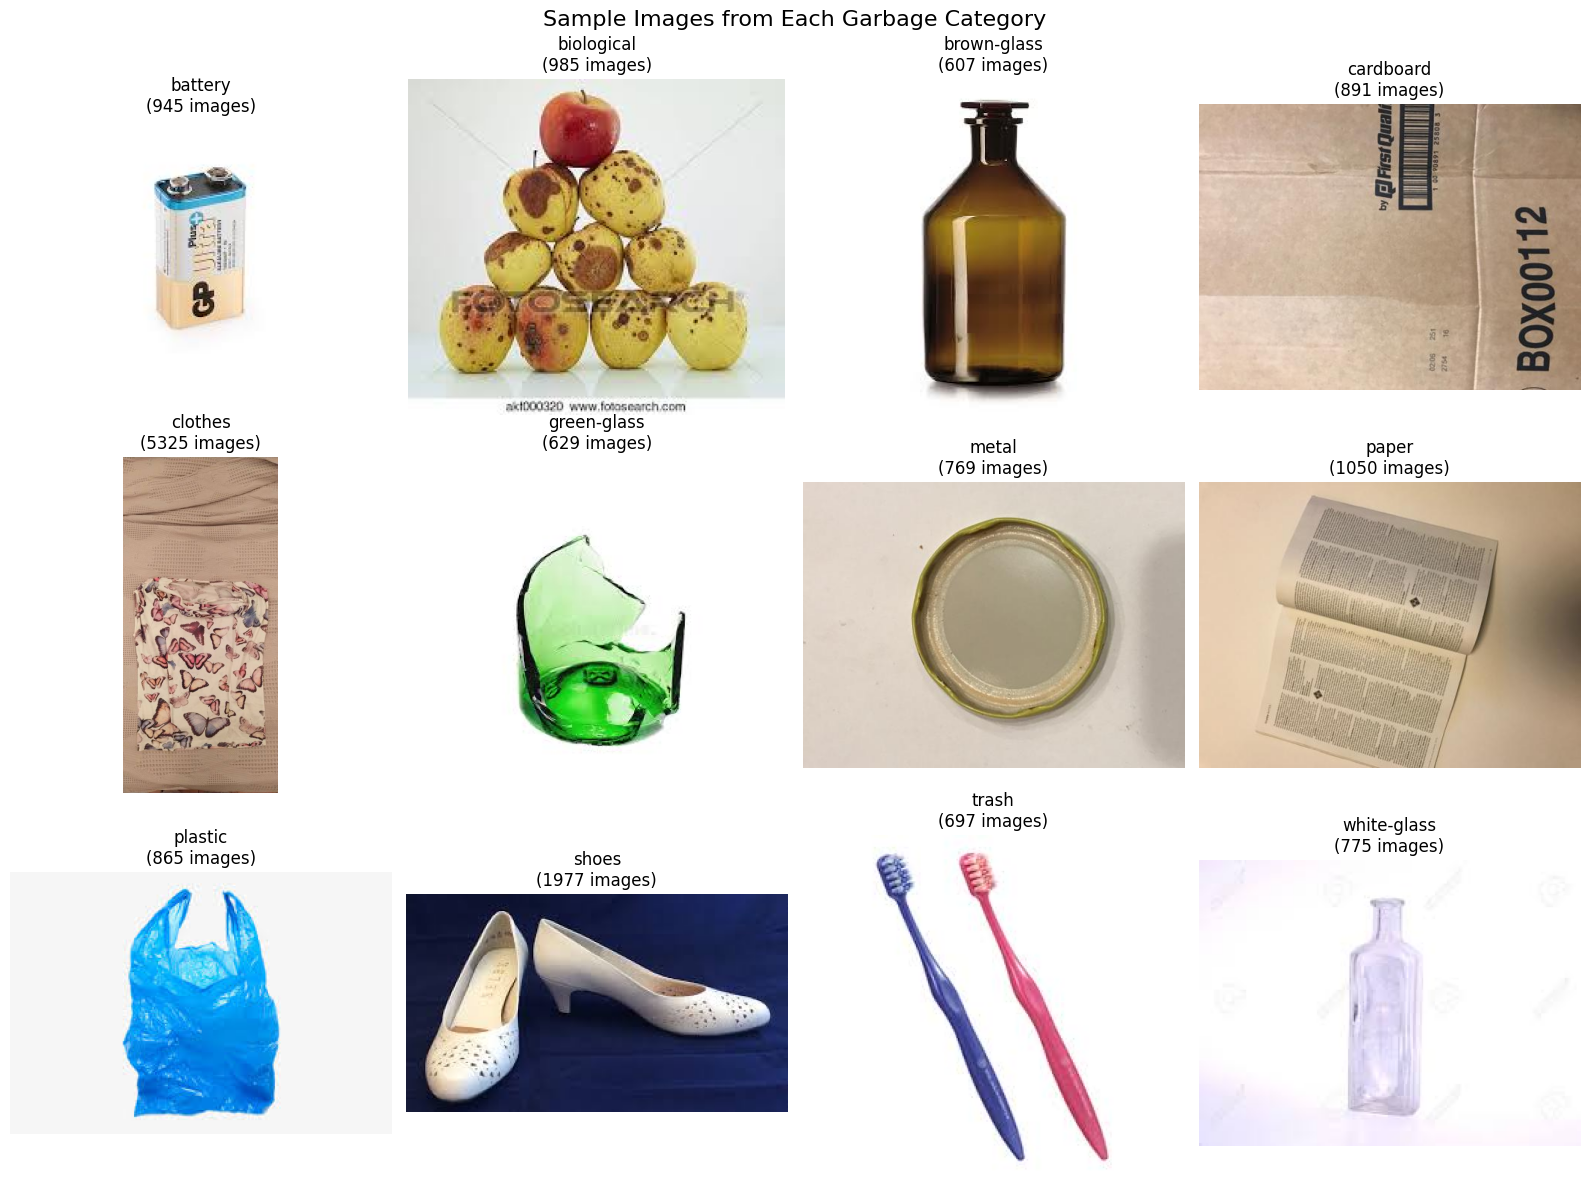

In [ ]:
# Display sample images from each class
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    class_path = data_dir / class_name
    image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))

    if image_files:
        # Load and display first image
        img_path = image_files[0]
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}\n({len(image_files)} images)', fontsize=12)
        axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, 'No images', ha='center', va='center')
        axes[i].set_title(class_name)
        axes[i].axis('off')

plt.suptitle('Sample Images from Each Garbage Category', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

## 5. Data Loading and Preprocessing

In [ ]:
# Load datasets using tf.keras.utils.image_dataset_from_directory
print("Loading training dataset...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=CONFIG['VALIDATION_SPLIT'],
    subset="training",
    seed=CONFIG['SEED'],
    image_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE']
)

print("Loading validation dataset...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=CONFIG['VALIDATION_SPLIT'],
    subset="validation",
    seed=CONFIG['SEED'],
    image_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE']
)

# Get class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"\nDataset loaded successfully!")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Calculate dataset sizes
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()

print(f"\nDataset sizes:")
print(f"  Training batches: {train_size}")
print(f"  Validation batches: {val_size}")
print(f"  Approximate training images: {train_size * CONFIG['BATCH_SIZE']}")
print(f"  Approximate validation images: {val_size * CONFIG['BATCH_SIZE']}")

Loading training dataset...
Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Loading validation dataset...
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.

Dataset loaded successfully!
Number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']

Dataset sizes:
  Training batches: 776
  Validation batches: 194
  Approximate training images: 12416
  Approximate validation images: 3104


## 6. Data Augmentation and Preprocessing

In [ ]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
], name="data_augmentation")

# Preprocessing function
def process_data(image, label, augment=False):
    # Convert to float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    if augment:
        image = data_augmentation(image, training=True)

    # Apply EfficientNet preprocessing
    image = preprocess_input(image * 255.0)  # preprocess_input expects [0, 255]

    return image, label

# Apply preprocessing
print("Applying data preprocessing and augmentation...")
train_ds_processed = train_ds.map(
    lambda x, y: process_data(x, y, augment=True),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)

val_ds_processed = val_ds.map(
    lambda x, y: process_data(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(tf.data.AUTOTUNE)

print("Data preprocessing completed!")

Applying data preprocessing and augmentation...
Data preprocessing completed!


## 7. Visualize Augmented Data

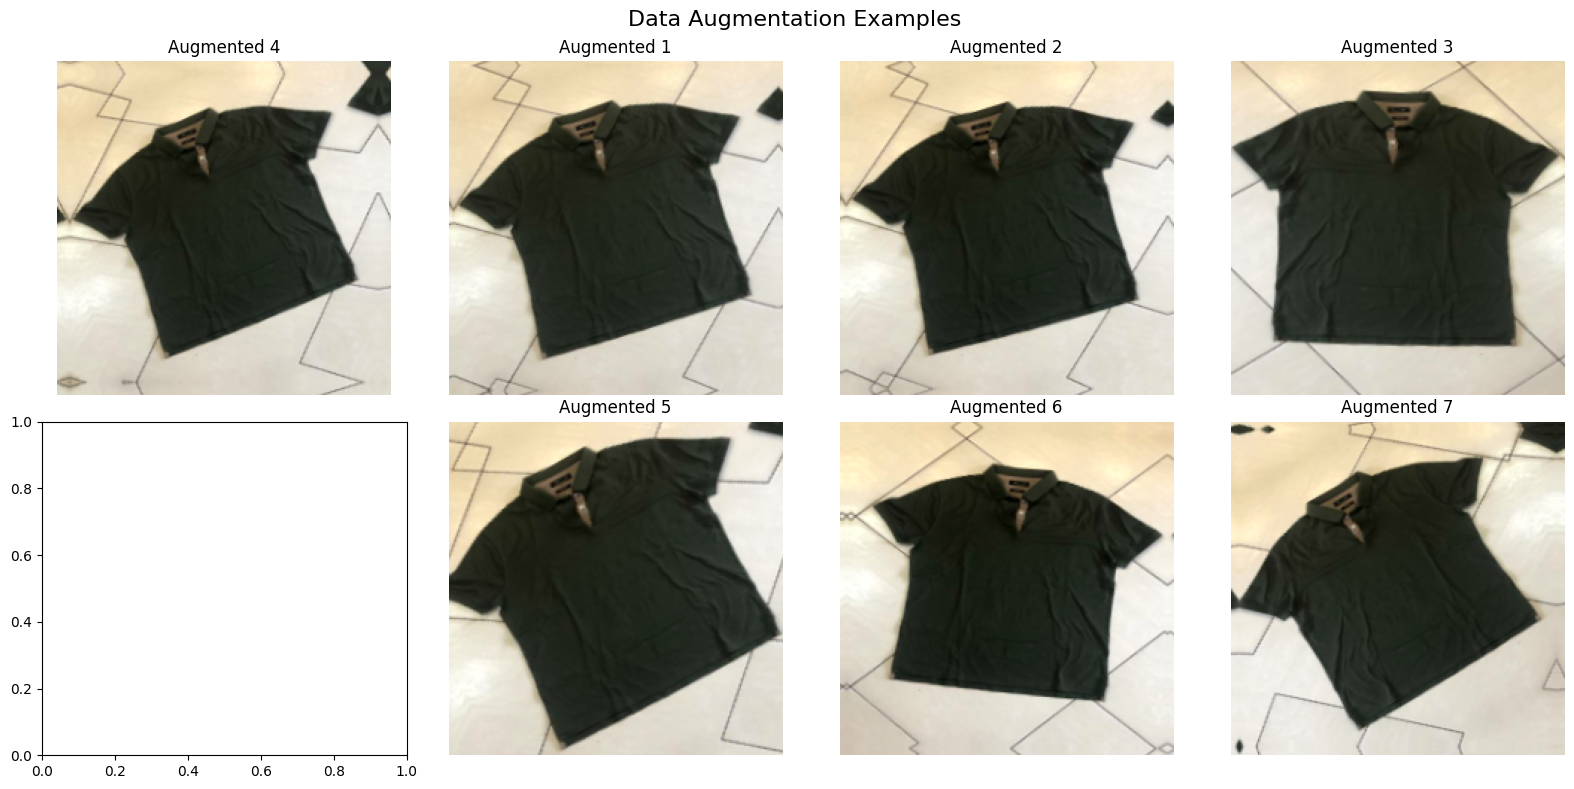

In [ ]:
# Visualize data augmentation effects
# Take one batch and show original vs augmented
sample_batch = train_ds.take(1)

for images, labels in sample_batch:
    # Show original and augmented versions of first image
    sample_image = images[0]
    sample_image = tf.cast(sample_image, tf.float32) / 255.0

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))

    # Original image
    axes[0, 0].imshow(sample_image)
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')

    # Show 7 augmented versions
    for i in range(7):
        row = i // 4
        col = (i + 1) % 4

        augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)[0]
        axes[row, col].imshow(tf.clip_by_value(augmented, 0, 1))
        axes[row, col].set_title(f'Augmented {i+1}')
        axes[row, col].axis('off')

    plt.suptitle('Data Augmentation Examples', fontsize=16)
    plt.tight_layout()
    plt.show()
    break

## 8. Model Architecture

In [ ]:
# Create EfficientNetB0 base model
print("Building EfficientNetB0 model...")

# Load pre-trained EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=CONFIG['IMAGE_SIZE'] + (3,),
    include_top=False,
    weights='imagenet'
)

# Freeze base model for transfer learning
base_model.trainable = False

print(f"Base model loaded: {base_model.name}")
print(f"Base model parameters: {base_model.count_params():,}")
print(f"Base model trainable: {base_model.trainable}")

Building EfficientNetB0 model...
Base model loaded: efficientnetb0
Base model parameters: 4,049,571
Base model trainable: False


In [ ]:
# Build complete model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=CONFIG['IMAGE_SIZE'] + (3,)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', name='feature_layer'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')
], name='garbage_classifier')

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("\nModel Architecture:")
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(var).numpy() for var in model.trainable_variables]):,}")


Model Architecture:


Model: "garbage_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification_layer (Dense)    │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,215,087 (16.08 MB)

 Trainable params: 165,516 (646.55 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


Total parameters: 4,215,087
Trainable parameters: 165,516


## 9. Training Callbacks

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

print("Training callbacks configured:")
for callback in callbacks:
    print(f"  - {callback.__class__.__name__}")

Training callbacks configured:
  - ModelCheckpoint
  - ReduceLROnPlateau
  - EarlyStopping


## 10. Model Training

In [ ]:
# Train the model
print(f"Starting training for {CONFIG['EPOCHS']} epochs...")
print("=" * 50)

history = model.fit(
    train_ds_processed,
    validation_data=val_ds_processed,
    epochs=CONFIG['EPOCHS'],
    callbacks=callbacks,
    verbose=1
)

print("\n🎉 Training completed!")

Starting training for 20 epochs...
Epoch 1/20
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8119 - loss: 0.6255
Epoch 1: val_accuracy improved from -inf to 0.94973, saving model to best_model.h5


776/776 ━━━━━━━━━━━━━━━━━━━━ 219s 69ms/step - accuracy: 0.8121 - loss: 0.6248 - val_accuracy: 0.9497 - val_loss: 0.1590 - learning_rate: 0.0010
Epoch 2/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9415 - loss: 0.1905
Epoch 2: val_accuracy improved from 0.94973 to 0.95682, saving model to best_model.h5


776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9415 - loss: 0.1905 - val_accuracy: 0.9568 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 3/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9559 - loss: 0.1422
Epoch 3: val_accuracy did not improve from 0.95682
776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9559 - loss: 0.1422 - val_accuracy: 0.9536 - val_loss: 0.1428 - learning_rate: 0.0010
Epoch 4/20
774/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9566 - loss: 0.1334
Epoch 4: val_accuracy improved from 0.95682 to 0.95778, saving model to best_model.h5


776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9566 - loss: 0.1334 - val_accuracy: 0.9578 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 5/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9651 - loss: 0.1028
Epoch 5: val_accuracy improved from 0.95778 to 0.96004, saving model to best_model.h5


776/776 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9651 - loss: 0.1028 - val_accuracy: 0.9600 - val_loss: 0.1325 - learning_rate: 0.0010
Epoch 6/20
774/776 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9677 - loss: 0.0920
Epoch 6: val_accuracy did not improve from 0.96004
776/776 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.9677 - loss: 0.0920 - val_accuracy: 0.9555 - val_loss: 0.1499 - learning_rate: 0.0010
Epoch 7/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9714 - loss: 0.0845
Epoch 7: val_accuracy did not improve from 0.96004
776/776 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.9714 - loss: 0.0845 - val_accuracy: 0.9568 - val_loss: 0.1489 - learning_rate: 0.0010
Epoch 8/20
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9713 - loss: 0.0834
Epoch 8: val_accuracy did not improve from 0.96004

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9713 - loss: 0.0834 - v

776/776 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9786 - loss: 0.0608 - val_accuracy: 0.9649 - val_loss: 0.1282 - learning_rate: 5.0000e-04
Epoch 10/20
774/776 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9842 - loss: 0.0475
Epoch 10: val_accuracy did not improve from 0.96487
776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9842 - loss: 0.0475 - val_accuracy: 0.9594 - val_loss: 0.1362 - learning_rate: 5.0000e-04
Epoch 11/20
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9830 - loss: 0.0504
Epoch 11: val_accuracy did not improve from 0.96487
776/776 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9830 - loss: 0.0504 - val_accuracy: 0.9623 - val_loss: 0.1376 - learning_rate: 5.0000e-04
Epoch 12/20
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9846 - loss: 0.0435
Epoch 12: val_accuracy did not improve from 0.96487

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
776/776 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9846

## 11. Training Visualization

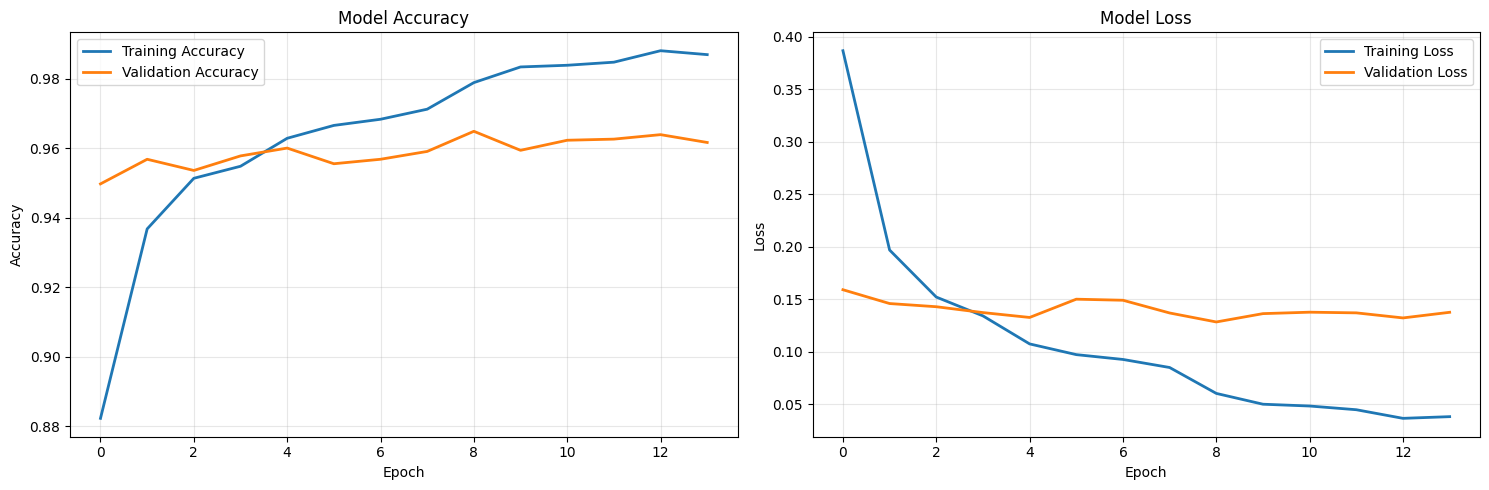

Final Training Accuracy: 0.9869 (98.69%)
Final Validation Accuracy: 0.9617 (96.17%)
Final Training Loss: 0.0380
Final Validation Loss: 0.1374


In [ ]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

plot_training_history(history)

## 12. Model Evaluation

In [ ]:
# Evaluate the model
print("Evaluating model on validation set...")
val_loss, val_accuracy = model.evaluate(val_ds_processed, verbose=1)

print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

Evaluating model on validation set...
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9655 - loss: 0.1348

Validation Results:
  Loss: 0.1282
  Accuracy: 0.9649 (96.49%)


## 13. Predictions and Confusion Matrix

In [ ]:
# Generate predictions for confusion matrix
print("Generating predictions for confusion matrix...")

y_true = []
y_pred = []

for images, labels in val_ds_processed:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f"Generated {len(y_true)} predictions")

Generating predictions for confusion matrix...
Generated 3103 predictions


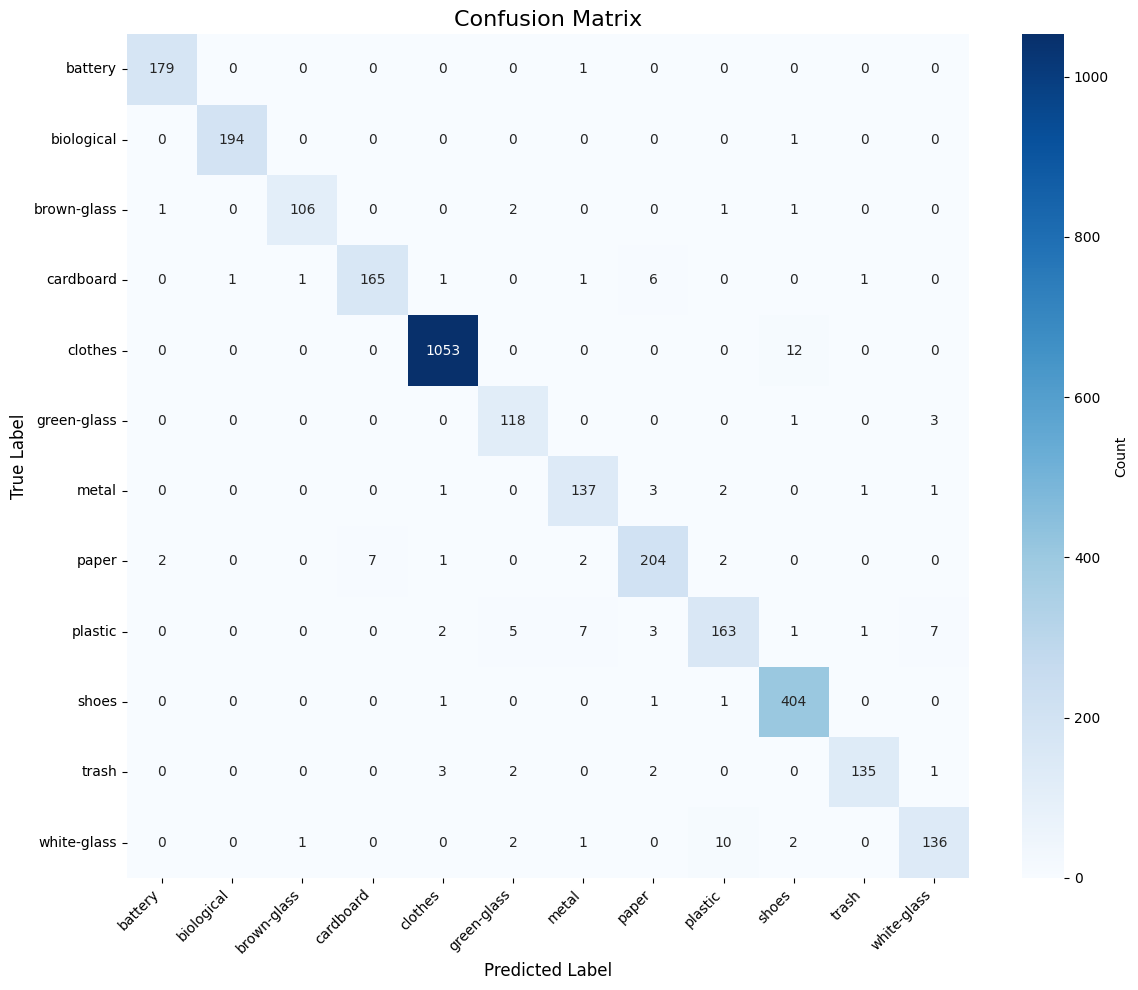


Classification Report:
              precision    recall  f1-score   support

     battery     0.9835    0.9944    0.9890       180
  biological     0.9949    0.9949    0.9949       195
 brown-glass     0.9815    0.9550    0.9680       111
   cardboard     0.9593    0.9375    0.9483       176
     clothes     0.9915    0.9887    0.9901      1065
 green-glass     0.9147    0.9672    0.9402       122
       metal     0.9195    0.9448    0.9320       145
       paper     0.9315    0.9358    0.9336       218
     plastic     0.9106    0.8624    0.8859       189
       shoes     0.9573    0.9926    0.9747       407
       trash     0.9783    0.9441    0.9609       143
 white-glass     0.9189    0.8947    0.9067       152

    accuracy                         0.9649      3103
   macro avg     0.9535    0.9510    0.9520      3103
weighted avg     0.9649    0.9649    0.9647      3103



In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

## 14. Sample Predictions Visualization

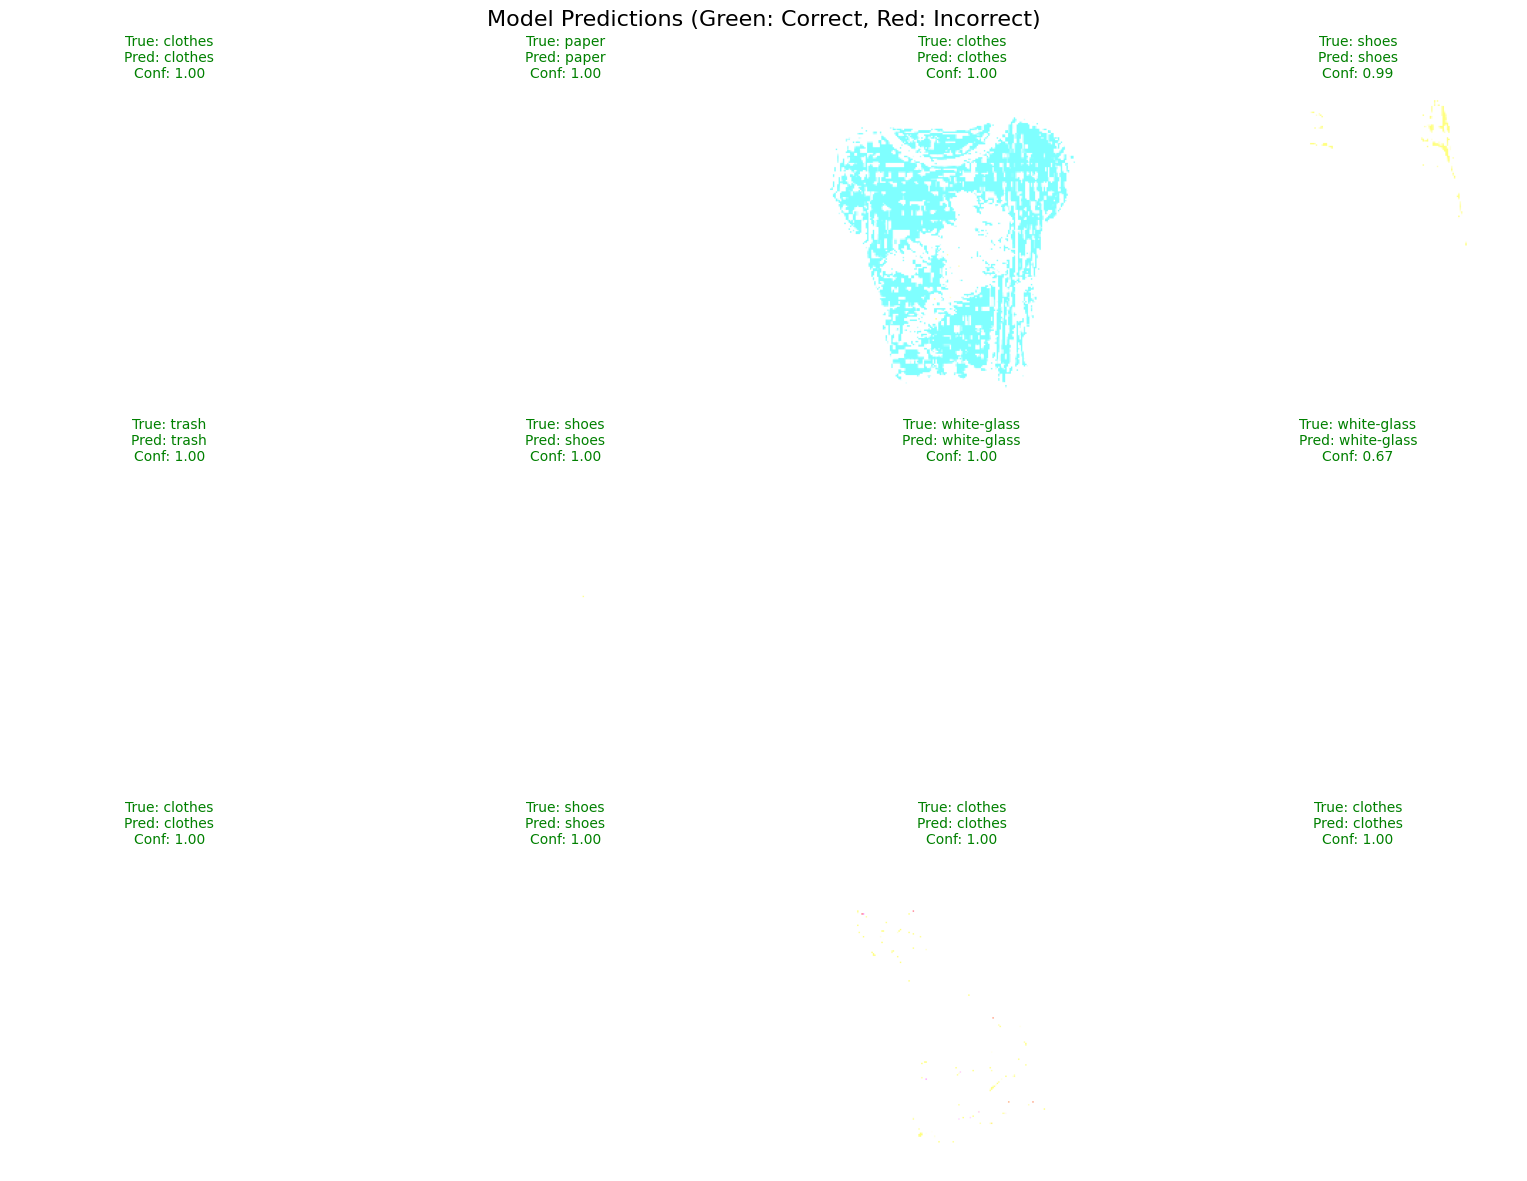

In [ ]:
# Visualize some predictions
def plot_predictions(dataset, model, class_names, num_images=12):
    plt.figure(figsize=(16, 12))

    images_shown = 0
    for images, labels in dataset.take(3):  # Take a few batches
        predictions = model.predict(images, verbose=0)

        for i in range(len(images)):
            if images_shown >= num_images:
                break

            plt.subplot(3, 4, images_shown + 1)

            # Denormalize image for display
            img = images[i].numpy()
            # Convert from EfficientNet preprocessing back to [0,1]
            img = (img + 1) / 2  # Rough approximation for display
            img = np.clip(img, 0, 1)

            plt.imshow(img)

            true_label = class_names[labels[i]]
            pred_label = class_names[np.argmax(predictions[i])]
            confidence = np.max(predictions[i])

            color = 'green' if true_label == pred_label else 'red'
            plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}',
                     color=color, fontsize=10)
            plt.axis('off')

            images_shown += 1

        if images_shown >= num_images:
            break

    plt.suptitle('Model Predictions (Green: Correct, Red: Incorrect)', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_predictions(val_ds_processed, model, class_names)

## 15. Model Saving

In [ ]:
# Save the trained model
print("Saving trained model...")
model.save('garbage_classifier_model.keras')
print("✅ Model saved as 'garbage_classifier_model.keras'")

# Save model in SavedModel format as well
model.save('garbage_classifier.keras')
print("✅ Model saved as 'garbage_classifier_savedmodel'")

# Get model size
model_size = os.path.getsize('garbage_classifier_model.keras') / (1024 * 1024)
print(f"Model size: {model_size:.2f} MB")

Saving trained model...
✅ Model saved as 'garbage_classifier_model.keras'
✅ Model saved as 'garbage_classifier_savedmodel'
Model size: 18.15 MB


## 16. TensorFlow Lite Conversion

In [ ]:
# Convert to TensorFlow Lite
print("Converting model to TensorFlow Lite format...")

# Basic conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Create paths for both local and Drive storage
local_tflite_path = 'garbage_classifier.tflite'
drive_tflite_path = os.path.join(CONFIG['MODEL_SAVE_DIR'], 'garbage_classifier.tflite')

# Save TFLite model locally
with open(local_tflite_path, 'wb') as f:
    f.write(tflite_model)

# Also save to Google Drive if running on Colab
if IN_COLAB:
    with open(drive_tflite_path, 'wb') as f:
        f.write(tflite_model)
    print(f"✅ TFLite model saved to Drive at: {drive_tflite_path}")

print(f"✅ TFLite model saved locally as: {local_tflite_path}")

# Get TFLite model size
tflite_size = os.path.getsize(local_tflite_path) / (1024 * 1024)
print(f"TFLite model size: {tflite_size:.2f} MB")
print(f"Size reduction: {((model_size - tflite_size) / model_size * 100):.1f}%")

Converting model to TensorFlow Lite format...
Saved artifact at '/tmp/tmp6a5vdfmr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_243')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  134013602325776: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134013602328464: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134011717131856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717133008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717134928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717132624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717132048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717137808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717135120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717136656

## 17. Quantized TensorFlow Lite Model

In [ ]:
# Create quantized version for even smaller size
print("Creating quantized TensorFlow Lite model...")

# Dynamic range quantization
converter_quantized = tf.lite.TFLiteConverter.from_keras_model(model)
converter_quantized.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter_quantized.convert()

# Create paths for both local and Drive storage
local_quantized_path = 'garbage_classifier_quantized.tflite'
drive_quantized_path = os.path.join(CONFIG['MODEL_SAVE_DIR'], 'garbage_classifier_quantized.tflite')

# Save quantized TFLite model locally
with open(local_quantized_path, 'wb') as f:
    f.write(tflite_quantized_model)

# Also save to Google Drive if running on Colab
if IN_COLAB:
    with open(drive_quantized_path, 'wb') as f:
        f.write(tflite_quantized_model)
    print(f"✅ Quantized TFLite model saved to Drive at: {drive_quantized_path}")

print(f"✅ Quantized TFLite model saved locally as: {local_quantized_path}")

# Get quantized model size
tflite_quantized_size = os.path.getsize(local_quantized_path) / (1024 * 1024)
print(f"Quantized TFLite model size: {tflite_quantized_size:.2f} MB")
print(f"Size reduction from original: {((model_size - tflite_quantized_size) / model_size * 100):.1f}%")
print(f"Size reduction from unquantized TFLite: {((tflite_size - tflite_quantized_size) / tflite_size * 100):.1f}%")

Creating quantized TensorFlow Lite model...
Saved artifact at '/tmp/tmpryve2xsk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_243')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  134013602325776: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134013602328464: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134011717131856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717133008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717134928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717132624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717132048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717137808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717135120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134011717136656: 

## 18. TensorFlow Lite Model Testing

In [ ]:
# Test TensorFlow Lite model
def test_tflite_model(tflite_model_path, test_dataset, num_samples=100):
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print(f"Testing TFLite model: {tflite_model_path}")
    print(f"Input shape: {input_details[0]['shape']}")
    print(f"Output shape: {output_details[0]['shape']}")

    correct_predictions = 0
    total_predictions = 0

    for images, labels in test_dataset.take(num_samples // CONFIG['BATCH_SIZE']):
        for i in range(len(images)):
            if total_predictions >= num_samples:
                break

            # Prepare input
            input_data = np.expand_dims(images[i].numpy(), axis=0).astype(np.float32)

            # Run inference
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()

            # Get prediction
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_class = np.argmax(output_data[0])
            true_class = labels[i].numpy()

            if predicted_class == true_class:
                correct_predictions += 1

            total_predictions += 1

        if total_predictions >= num_samples:
            break

    accuracy = correct_predictions / total_predictions
    print(f"TFLite model accuracy on {total_predictions} samples: {accuracy:.4f} ({accuracy*100:.2f}%)")
    return accuracy

# Test both TFLite models
print("Testing TensorFlow Lite models...")
print("=" * 50)

regular_tflite_acc = test_tflite_model(tflite_model_path, val_ds_processed)
print()
quantized_tflite_acc = test_tflite_model(tflite_quantized_path, val_ds_processed)

print(f"\nAccuracy comparison:")
print(f"  Original Keras model: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Regular TFLite model: {regular_tflite_acc:.4f} ({regular_tflite_acc*100:.2f}%)")
print(f"  Quantized TFLite model: {quantized_tflite_acc:.4f} ({quantized_tflite_acc*100:.2f}%)")

Testing TensorFlow Lite models...


NameError: name 'tflite_model_path' is not defined

## 19. Model Summary and Results

In [ ]:
# Final summary
print("🎉 GARBAGE CLASSIFICATION MODEL TRAINING COMPLETE!")
print("=" * 60)

print(f"\n📊 Dataset Information:")
print(f"  Classes: {num_classes}")
print(f"  Class names: {', '.join(class_names)}")
print(f"  Total images: ~{(train_size + val_size) * CONFIG['BATCH_SIZE']}")
print(f"  Training images: ~{train_size * CONFIG['BATCH_SIZE']}")
print(f"  Validation images: ~{val_size * CONFIG['BATCH_SIZE']}")

print(f"\n🏗️  Model Architecture:")
print(f"  Base model: EfficientNetB0")
print(f"  Transfer learning: Yes")
print(f"  Input size: {CONFIG['IMAGE_SIZE']}")
print(f"  Total parameters: {model.count_params():,}")

print(f"\n📈 Training Results:")
print(f"  Final validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print(f"  Final validation loss: {val_loss:.4f}")
print(f"  Training epochs: {len(history.history['accuracy'])}")

print(f"\n💾 Generated Files:")
print(f"  Keras model: garbage_classifier_model.h5 ({model_size:.2f} MB)")
print(f"  SavedModel: garbage_classifier_savedmodel/")
print(f"  TFLite model: {tflite_model_path} ({tflite_size:.2f} MB)")
print(f"  Quantized TFLite: {tflite_quantized_path} ({tflite_quantized_size:.2f} MB)")
print(f"  Best model checkpoint: best_model.h5")

print(f"\n📱 Deployment Ready:")
print(f"  ✅ Model optimized for edge devices")
print(f"  ✅ TensorFlow Lite format available")
print(f"  ✅ Quantized version for minimal size")
print(f"  ✅ Compatible with mobile/embedded deployment")

print(f"\n🎯 Next Steps:")
print(f"  1. Deploy TFLite model to your target device")
print(f"  2. Implement inference pipeline with preprocessing")
print(f"  3. Test on real-world garbage images")
print(f"  4. Fine-tune if needed with additional data")

🎉 GARBAGE CLASSIFICATION MODEL TRAINING COMPLETE!

📊 Dataset Information:
  Classes: 12
  Class names: battery, biological, brown-glass, cardboard, clothes, green-glass, metal, paper, plastic, shoes, trash, white-glass
  Total images: ~15520
  Training images: ~12416
  Validation images: ~3104

🏗️  Model Architecture:
  Base model: EfficientNetB0
  Transfer learning: Yes
  Input size: (224, 224)
  Total parameters: 4,215,087

📈 Training Results:
  Final validation accuracy: 0.9649 (96.49%)
  Final validation loss: 0.1282
  Training epochs: 14

💾 Generated Files:
  Keras model: garbage_classifier_model.h5 (18.15 MB)
  SavedModel: garbage_classifier_savedmodel/


NameError: name 'tflite_model_path' is not defined